<a href="https://www.kaggle.com/code/soumyaranjansahoo33/melanoma-final?scriptVersionId=285656856" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


In [2]:
# --- 1. Configuration and Setup ---
DATA_PATH = '/kaggle/input/siim-isic-melanoma-classification/'
IMAGE_PATH = os.path.join(DATA_PATH, 'jpeg/train')
CSV_PATH = os.path.join(DATA_PATH, 'train.csv')

# New directory for our augmented dataset
AUG_DATA_PATH = '/kaggle/working/original_augmented/'
AUG_IMAGE_PATH = os.path.join(AUG_DATA_PATH, 'jpeg')
AUG_CSV_PATH = os.path.join(AUG_DATA_PATH, 'augmented_train.csv')

# Create the directories, removing any old ones first
if os.path.exists(AUG_DATA_PATH):
    shutil.rmtree(AUG_DATA_PATH)
os.makedirs(AUG_IMAGE_PATH, exist_ok=True)

In [3]:
# --- 2. Data Loading and Balancing ---
print("Loading and creating a balanced dataset for augmentation...")
df = pd.read_csv(CSV_PATH)
#df.dropna(reset_index=True,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

Loading and creating a balanced dataset for augmentation...


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
32526,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
32527,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
32528,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
32529,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [4]:
malignant_df = df[df['target'] == 1].copy()
benign_df = df[df['target'] == 0].copy()

# Create initial balanced set
n_malignant = len(malignant_df)
n_sites = benign_df['anatom_site_general_challenge'].nunique()
n_per_site = n_malignant // n_sites
remainder = n_malignant % n_sites

benign_list = []
for site, group in benign_df.groupby('anatom_site_general_challenge'):
    sample_n = n_per_site + 1 if remainder > 0 else n_per_site
    benign_list.append(group.sample(n=sample_n, random_state=42))
    remainder -= 1
sampled_benign_df = pd.concat(benign_list)

balanced_df = pd.concat([malignant_df, sampled_benign_df], ignore_index=True)

In [5]:
# --- 3. Augmentation Process ---
print(f"Augmenting {len(balanced_df)} images to triple the dataset size...")
augmented_data = []
hflip = transforms.RandomHorizontalFlip(p=1.0)
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)

for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    img_name = row['image_name']
    original_img_path = os.path.join(IMAGE_PATH, f"{img_name}.jpg")
    image = Image.open(original_img_path)

    # 1. Original Image, 2. Flipped Image, 3. Color Jittered Image
    images_to_save = [(image, "orig"), (hflip(image), "flipped"), (color_jitter(image), "jittered")]
    for img, suffix in images_to_save:
        new_name = f"{img_name}_{suffix}.jpg"
        img.save(os.path.join(AUG_IMAGE_PATH, new_name))
        new_row = row.copy()
        new_row['image_name'] = new_name
        augmented_data.append(new_row)

augmented_df = pd.DataFrame(augmented_data)
augmented_df.to_csv(AUG_CSV_PATH, index=False)
print(f"Augmentation complete. New dataset size: {len(augmented_df)} images.")

Augmenting 1150 images to triple the dataset size...


  0%|          | 0/1150 [00:00<?, ?it/s]

Augmentation complete. New dataset size: 3450 images.


In [6]:
# --- 4. Show File Structure and CSV Preview ---
print("\n--- Generated File Structure ---")
print(f"Data saved in: {AUG_DATA_PATH}")
print("Directory contents:")
for dirname, _, filenames in os.walk(AUG_DATA_PATH):
    for filename in filenames[:5]: # Show first 5 files as an example
        print(os.path.join(dirname, filename))
    if len(filenames) > 5:
        print("...")

print("\n--- Preview of augmented_train.csv ---")
preview_df = pd.read_csv(AUG_CSV_PATH)
print(preview_df.head())
print("------------------------------------")


--- Generated File Structure ---
Data saved in: /kaggle/working/original_augmented/
Directory contents:
/kaggle/working/original_augmented/augmented_train.csv
/kaggle/working/original_augmented/jpeg/ISIC_8564474_flipped.jpg
/kaggle/working/original_augmented/jpeg/ISIC_9583969_flipped.jpg
/kaggle/working/original_augmented/jpeg/ISIC_0247330_jittered.jpg
/kaggle/working/original_augmented/jpeg/ISIC_1264950_orig.jpg
/kaggle/working/original_augmented/jpeg/ISIC_6056121_jittered.jpg
...

--- Preview of augmented_train.csv ---
                  image_name  patient_id     sex  age_approx  \
0      ISIC_0149568_orig.jpg  IP_0962375  female        55.0   
1   ISIC_0149568_flipped.jpg  IP_0962375  female        55.0   
2  ISIC_0149568_jittered.jpg  IP_0962375  female        55.0   
3      ISIC_0188432_orig.jpg  IP_0135517  female        50.0   
4   ISIC_0188432_flipped.jpg  IP_0135517  female        50.0   

  anatom_site_general_challenge diagnosis benign_malignant  target  
0               up

Using device: cuda
Loading augmented dataset...

--- Data Split Summary ---
Training set size:   2760 samples
Validation set size: 345 samples
Test set size:       345 samples
--------------------------


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 186MB/s]


--- Phase 1: Training Classifier Head ---


Epoch 1/5 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.5817 | Val Loss: 0.5042 | Train Acc: 0.6949 | Val Acc: 0.7304 | LR: 0.001000
Validation loss decreased (inf --> 0.5042). Saving model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/5 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.4896 | Val Loss: 0.4736 | Train Acc: 0.7725 | Val Acc: 0.7768 | LR: 0.000975
Validation loss decreased (0.5042 --> 0.4736). Saving model...


Epoch 3/5 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.4603 | Val Loss: 0.4370 | Train Acc: 0.7859 | Val Acc: 0.7884 | LR: 0.000978
Validation loss decreased (0.4736 --> 0.4370). Saving model...


Epoch 4/5 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.4244 | Val Loss: 0.4081 | Train Acc: 0.8011 | Val Acc: 0.8058 | LR: 0.000981
Validation loss decreased (0.4370 --> 0.4081). Saving model...


Epoch 5/5 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.4019 | Val Loss: 0.4226 | Train Acc: 0.8116 | Val Acc: 0.7913 | LR: 0.000984
EarlyStopping counter: 1/5

Finished Training.

--- Phase 2: Fine-Tuning Full Model ---


Epoch 1/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.3917 | Val Loss: 0.3947 | Train Acc: 0.8192 | Val Acc: 0.8058 | LR: 0.000010
Validation loss decreased (inf --> 0.3947). Saving model...


Epoch 2/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.3655 | Val Loss: 0.3768 | Train Acc: 0.8315 | Val Acc: 0.8290 | LR: 0.000010
Validation loss decreased (0.3947 --> 0.3768). Saving model...


Epoch 3/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.3472 | Val Loss: 0.3749 | Train Acc: 0.8467 | Val Acc: 0.8464 | LR: 0.000010
Validation loss decreased (0.3768 --> 0.3749). Saving model...


Epoch 4/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.3336 | Val Loss: 0.3658 | Train Acc: 0.8554 | Val Acc: 0.8377 | LR: 0.000010
Validation loss decreased (0.3749 --> 0.3658). Saving model...


Epoch 5/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.3231 | Val Loss: 0.3666 | Train Acc: 0.8667 | Val Acc: 0.8493 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 6/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.3061 | Val Loss: 0.3474 | Train Acc: 0.8739 | Val Acc: 0.8464 | LR: 0.000010
Validation loss decreased (0.3658 --> 0.3474). Saving model...


Epoch 7/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.2864 | Val Loss: 0.3389 | Train Acc: 0.8790 | Val Acc: 0.8551 | LR: 0.000010
Validation loss decreased (0.3474 --> 0.3389). Saving model...


Epoch 8/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.2908 | Val Loss: 0.3179 | Train Acc: 0.8754 | Val Acc: 0.8609 | LR: 0.000010
Validation loss decreased (0.3389 --> 0.3179). Saving model...


Epoch 9/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.2892 | Val Loss: 0.3149 | Train Acc: 0.8736 | Val Acc: 0.8609 | LR: 0.000010
Validation loss decreased (0.3179 --> 0.3149). Saving model...


Epoch 10/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.2725 | Val Loss: 0.3116 | Train Acc: 0.8880 | Val Acc: 0.8580 | LR: 0.000010
Validation loss decreased (0.3149 --> 0.3116). Saving model...


Epoch 11/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.2597 | Val Loss: 0.2987 | Train Acc: 0.8906 | Val Acc: 0.8609 | LR: 0.000010
Validation loss decreased (0.3116 --> 0.2987). Saving model...


Epoch 12/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.2638 | Val Loss: 0.2850 | Train Acc: 0.8967 | Val Acc: 0.8841 | LR: 0.000010
Validation loss decreased (0.2987 --> 0.2850). Saving model...


Epoch 13/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.2363 | Val Loss: 0.2881 | Train Acc: 0.9011 | Val Acc: 0.8754 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 14/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.2312 | Val Loss: 0.2733 | Train Acc: 0.9069 | Val Acc: 0.8928 | LR: 0.000010
Validation loss decreased (0.2850 --> 0.2733). Saving model...


Epoch 15/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.2260 | Val Loss: 0.2690 | Train Acc: 0.9138 | Val Acc: 0.8870 | LR: 0.000010
Validation loss decreased (0.2733 --> 0.2690). Saving model...


Epoch 16/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.2154 | Val Loss: 0.2494 | Train Acc: 0.9130 | Val Acc: 0.9014 | LR: 0.000010
Validation loss decreased (0.2690 --> 0.2494). Saving model...


Epoch 17/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.2117 | Val Loss: 0.2495 | Train Acc: 0.9098 | Val Acc: 0.8957 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 18/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.2070 | Val Loss: 0.2346 | Train Acc: 0.9203 | Val Acc: 0.9043 | LR: 0.000010
Validation loss decreased (0.2494 --> 0.2346). Saving model...


Epoch 19/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.1801 | Val Loss: 0.2440 | Train Acc: 0.9304 | Val Acc: 0.8957 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 20/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.1819 | Val Loss: 0.2343 | Train Acc: 0.9293 | Val Acc: 0.9101 | LR: 0.000010
Validation loss decreased (0.2346 --> 0.2343). Saving model...


Epoch 21/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1649 | Val Loss: 0.2259 | Train Acc: 0.9380 | Val Acc: 0.9130 | LR: 0.000010
Validation loss decreased (0.2343 --> 0.2259). Saving model...


Epoch 22/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1797 | Val Loss: 0.2193 | Train Acc: 0.9297 | Val Acc: 0.9188 | LR: 0.000010
Validation loss decreased (0.2259 --> 0.2193). Saving model...


Epoch 23/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1731 | Val Loss: 0.2206 | Train Acc: 0.9297 | Val Acc: 0.9130 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 24/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1580 | Val Loss: 0.2158 | Train Acc: 0.9406 | Val Acc: 0.9217 | LR: 0.000010
Validation loss decreased (0.2193 --> 0.2158). Saving model...


Epoch 25/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1482 | Val Loss: 0.1963 | Train Acc: 0.9460 | Val Acc: 0.9362 | LR: 0.000010
Validation loss decreased (0.2158 --> 0.1963). Saving model...


Epoch 26/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1515 | Val Loss: 0.1950 | Train Acc: 0.9453 | Val Acc: 0.9304 | LR: 0.000010
Validation loss decreased (0.1963 --> 0.1950). Saving model...


Epoch 27/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1400 | Val Loss: 0.2011 | Train Acc: 0.9449 | Val Acc: 0.9246 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 28/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1461 | Val Loss: 0.1797 | Train Acc: 0.9467 | Val Acc: 0.9391 | LR: 0.000010
Validation loss decreased (0.1950 --> 0.1797). Saving model...


Epoch 29/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1331 | Val Loss: 0.1676 | Train Acc: 0.9514 | Val Acc: 0.9449 | LR: 0.000010
Validation loss decreased (0.1797 --> 0.1676). Saving model...


Epoch 30/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1273 | Val Loss: 0.1699 | Train Acc: 0.9536 | Val Acc: 0.9420 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 31/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1359 | Val Loss: 0.1649 | Train Acc: 0.9467 | Val Acc: 0.9478 | LR: 0.000010
Validation loss decreased (0.1676 --> 0.1649). Saving model...


Epoch 32/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1295 | Val Loss: 0.1624 | Train Acc: 0.9511 | Val Acc: 0.9507 | LR: 0.000010
Validation loss decreased (0.1649 --> 0.1624). Saving model...


Epoch 33/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1120 | Val Loss: 0.1719 | Train Acc: 0.9591 | Val Acc: 0.9536 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 34/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1056 | Val Loss: 0.1541 | Train Acc: 0.9623 | Val Acc: 0.9507 | LR: 0.000010
Validation loss decreased (0.1624 --> 0.1541). Saving model...


Epoch 35/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.1243 | Val Loss: 0.1448 | Train Acc: 0.9594 | Val Acc: 0.9623 | LR: 0.000010
Validation loss decreased (0.1541 --> 0.1448). Saving model...


Epoch 36/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1026 | Val Loss: 0.1370 | Train Acc: 0.9598 | Val Acc: 0.9536 | LR: 0.000010
Validation loss decreased (0.1448 --> 0.1370). Saving model...


Epoch 37/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.1007 | Val Loss: 0.1323 | Train Acc: 0.9609 | Val Acc: 0.9536 | LR: 0.000010
Validation loss decreased (0.1370 --> 0.1323). Saving model...


Epoch 38/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0962 | Val Loss: 0.1392 | Train Acc: 0.9678 | Val Acc: 0.9507 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 39/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0868 | Val Loss: 0.1145 | Train Acc: 0.9681 | Val Acc: 0.9623 | LR: 0.000010
Validation loss decreased (0.1323 --> 0.1145). Saving model...


Epoch 40/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0887 | Val Loss: 0.1196 | Train Acc: 0.9692 | Val Acc: 0.9652 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 41/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0869 | Val Loss: 0.1296 | Train Acc: 0.9667 | Val Acc: 0.9565 | LR: 0.000010
EarlyStopping counter: 2/5


Epoch 42/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0842 | Val Loss: 0.1131 | Train Acc: 0.9692 | Val Acc: 0.9681 | LR: 0.000010
Validation loss decreased (0.1145 --> 0.1131). Saving model...


Epoch 43/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0817 | Val Loss: 0.1050 | Train Acc: 0.9707 | Val Acc: 0.9681 | LR: 0.000010
Validation loss decreased (0.1131 --> 0.1050). Saving model...


Epoch 44/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0873 | Val Loss: 0.1076 | Train Acc: 0.9659 | Val Acc: 0.9623 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 45/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0820 | Val Loss: 0.0917 | Train Acc: 0.9670 | Val Acc: 0.9739 | LR: 0.000010
Validation loss decreased (0.1050 --> 0.0917). Saving model...


Epoch 46/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0804 | Val Loss: 0.1001 | Train Acc: 0.9714 | Val Acc: 0.9652 | LR: 0.000010
EarlyStopping counter: 1/5


Epoch 47/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0815 | Val Loss: 0.1026 | Train Acc: 0.9725 | Val Acc: 0.9652 | LR: 0.000010
EarlyStopping counter: 2/5


Epoch 48/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0703 | Val Loss: 0.0943 | Train Acc: 0.9761 | Val Acc: 0.9681 | LR: 0.000010
EarlyStopping counter: 3/5


Epoch 49/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0816 | Val Loss: 0.0978 | Train Acc: 0.9678 | Val Acc: 0.9739 | LR: 0.000010
EarlyStopping counter: 4/5


Epoch 50/50 [Train]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0720 | Val Loss: 0.0936 | Train Acc: 0.9739 | Val Acc: 0.9681 | LR: 0.000010
EarlyStopping counter: 5/5
Early stopping triggered

Finished Training.

--- Loading best model for final TEST evaluation ---


Testing:   0%|          | 0/11 [00:00<?, ?it/s]


--- TEST SET RESULTS ---
Test Accuracy: 0.9681
Test AUC:      0.9846
Test F1-Score:   0.9685

Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.98      0.95      0.97       173
   Malignant       0.95      0.98      0.97       172

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345


Confusion Matrix (Test Set):


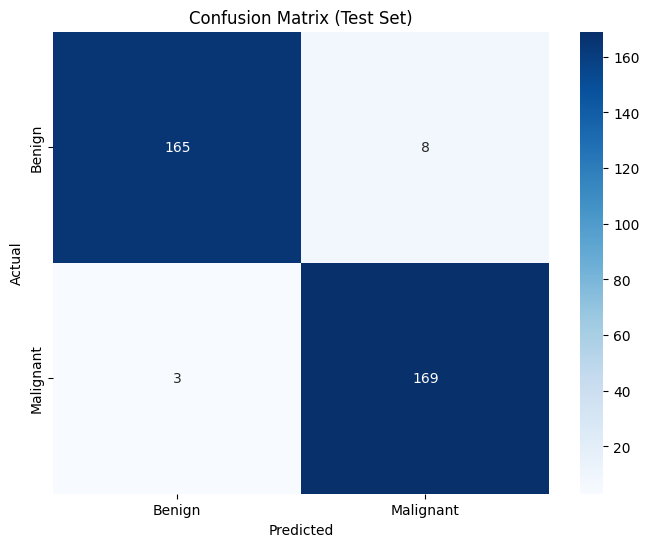

In [7]:

# --- 1. Configuration and Setup ---
# This script assumes the augmented data has already been created.
# Paths now point to the augmented dataset directory.
AUG_DATA_PATH = '/kaggle/working/original_augmented/'
AUG_IMAGE_PATH = os.path.join(AUG_DATA_PATH, 'jpeg')
AUG_CSV_PATH = os.path.join(AUG_DATA_PATH, 'augmented_train.csv')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Model & Training parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_HEAD = 5
EPOCHS_FULL = 50
LR_HEAD = 1e-3
LR_FULL = 1e-5
PATIENCE = 5
MODEL_SAVE_PATH = 'best_efficientnet_model.pth'

# --- 2. Load Augmented Data and Split (80/10/10) ---
print("Loading augmented dataset...")
augmented_df = pd.read_csv(AUG_CSV_PATH)

# Preprocessing
augmented_df['sex'] = pd.to_numeric(augmented_df['sex'].map({'male': 0, 'female': 1}))
numerical_features = ['age_approx', 'sex']
categorical_features = ['anatom_site_general_challenge']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# First split: 80% train, 20% temp (for validation and test)
train_df, temp_df = train_test_split(augmented_df, test_size=0.2, random_state=42, stratify=augmented_df['target'])
# Second split: split the 20% temp into 10% validation and 10% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['target'])

preprocessor.fit(train_df[numerical_features + categorical_features])

print("\n--- Data Split Summary ---")
print(f"Training set size:   {len(train_df)} samples")
print(f"Validation set size: {len(val_df)} samples")
print(f"Test set size:       {len(test_df)} samples")
print("--------------------------")

# --- 3. Dataset and DataLoader Classes ---
class MelanomaDataset(Dataset):
    def __init__(self, df, tabular_preprocessor, image_dir, transform=None):
        self.df = df
        self.tabular_preprocessor = tabular_preprocessor
        self.image_dir = image_dir
        self.transform = transform
        self.tabular_data = self.tabular_preprocessor.transform(self.df[numerical_features + categorical_features])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        tabular = torch.tensor(self.tabular_data[idx], dtype=torch.float)
        label = torch.tensor(row['target'], dtype=torch.float)
        return image, tabular, label

# --- 4. EfficientNet-B0 Multimodal Model ---
class MultimodalEfficientNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalEfficientNet, self).__init__()
        self.image_branch = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_image_features = self.image_branch.classifier[1].in_features
        self.image_branch.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_image_features, 128)
        )
        self.tabular_branch = nn.Sequential(nn.Linear(num_tabular_features, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.3))
        self.fusion = nn.Linear(128 + 32, 64)
        self.classifier = nn.Sequential(nn.ReLU(), nn.Dropout(0.5), nn.Linear(64, 1))
    def forward(self, image, tabular):
        image_features = self.image_branch(image)
        tabular_features = self.tabular_branch(tabular)
        combined_features = torch.cat([image_features, tabular_features], dim=1)
        fused = self.fusion(combined_features)
        output = self.classifier(fused)
        return output

# --- 5. Training and Evaluation Functions ---
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='best_model.pth'):
        self.patience, self.verbose, self.path = patience, verbose, path
        self.counter, self.best_score, self.early_stop, self.val_loss_min = 0, None, False, np.Inf
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose: print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        if self.verbose: print(f'Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, max_epochs, patience):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stopper = EarlyStopping(patience=patience, verbose=True, path=MODEL_SAVE_PATH)
    for epoch in range(max_epochs):
        model.train()
        train_loss, train_corrects = 0.0, 0
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]", leave=False)
        for images, tabular, labels in train_loop:
            images, tabular, labels = images.to(DEVICE), tabular.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_corrects += torch.sum(preds == labels.data)
            train_loop.set_postfix(loss=loss.item())
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for images, tabular, labels in val_loader:
                images, tabular, labels_dev = images.to(DEVICE), tabular.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
                outputs = model(images, tabular)
                loss = criterion(outputs, labels_dev)
                val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_corrects += torch.sum(preds == labels_dev.data)
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_train_acc = train_corrects.double() / len(train_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)
        history['train_loss'].append(epoch_train_loss); history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc.item()); history['val_acc'].append(epoch_val_acc.item())
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f} | LR: {current_lr:.6f}")
        scheduler.step(epoch_val_loss)
        early_stopper(epoch_val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered")
            break
    print("\nFinished Training.")
    return history

# --- 6. Main Execution ---
# DataLoaders with more advanced augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])
val_transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = MelanomaDataset(train_df, preprocessor, AUG_IMAGE_PATH, transform=train_transform)
val_dataset = MelanomaDataset(val_df, preprocessor, AUG_IMAGE_PATH, transform=val_transform)
test_dataset = MelanomaDataset(test_df, preprocessor, AUG_IMAGE_PATH, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Instantiate Model
num_tab_features = preprocessor.transform(train_df.head(1)[numerical_features + categorical_features]).shape[1]
model = MultimodalEfficientNet(num_tab_features).to(DEVICE)

# --- Two-Phase Training ---
# Phase 1: Train the head
for param in model.image_branch.parameters(): param.requires_grad = False
for param in model.image_branch.classifier.parameters(): param.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_HEAD)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_HEAD)
print("--- Phase 1: Training Classifier Head ---")
history_head = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, max_epochs=EPOCHS_HEAD, patience=PATIENCE)

# Phase 2: Fine-tune the full model
for param in model.parameters(): param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=LR_FULL)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FULL)
print("\n--- Phase 2: Fine-Tuning Full Model ---")
history_full = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, max_epochs=EPOCHS_FULL, patience=PATIENCE)

# --- 7. Final Evaluation on the HOLD-OUT TEST SET ---
print("\n--- Loading best model for final TEST evaluation ---")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

model.eval()
test_preds, test_labels, test_probs = [], [], []
with torch.no_grad():
    for images, tabular, labels in tqdm(test_loader, desc="Testing"):
        images, tabular = images.to(DEVICE), tabular.to(DEVICE)
        outputs = model(images, tabular)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs)

# --- Final Reports for the TEST SET ---
test_accuracy = accuracy_score(test_labels, test_preds)
auc_score = roc_auc_score(test_labels, test_probs)
f1 = f1_score(test_labels, test_preds)
print(f"\n--- TEST SET RESULTS ---")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC:      {auc_score:.4f}")
print(f"Test F1-Score:   {f1:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(test_labels, test_preds, target_names=['Benign', 'Malignant']))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix (Test Set)'); plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.show()